# Mechanistic Interpretability on Agents with ARES

**Detecting and Steering Rule Violations in Twenty Questions**

This notebook walks through an end-to-end mechanistic interpretability pipeline on an LLM agent using [ARES](https://github.com/withmartian/ares). We take an agent that plays Twenty Questions, find where rule violations are represented in its model's activations, and causally steer it toward compliance.

### Pipeline overview

| Phase | Goal | Key output |
|-------|------|------------|
| **Data collection** | Run episodes, cache activations at every step | `episode_*.pt` files with activations + oracle labels |
| **Probing** | Does the model *know* it's about to break the rules? | Per-step linear probe accuracy |
| **Steering vector analysis** | How does the valid/invalid direction evolve? | Cosine similarity heatmap, PCA trajectory |
| **Intervention** | Can we *fix* the behaviour by adding a steering vector? | Invalid rate reduction from 69% → 58% |

## Setup

```bash
uv sync --all-groups --extra transformer-lens
```

In [1]:
import json
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Image, display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
# Paths to pre-computed results (from running the case study scripts)
BASE_DATA_DIR = pathlib.Path("../../outputs")
DATA_DIR = BASE_DATA_DIR / "20q_data"
PROBE_RESULTS_DIR = BASE_DATA_DIR / "20q_probing_results"
STEERING_RESULTS_DIR = BASE_DATA_DIR / "deterministic_20q_steering_results/results_20ep"
EVOLUTION_DIR = BASE_DATA_DIR / "20q_steering_vector_evolution"

SEED = 42
TRAIN_RATIO = 0.8
MIN_CLASS_SAMPLES = 5
POOLING = "last-prompt"

---

## Phase 0: Data Collection — Caching Activations Across Agent Episodes

The key idea: The Mech Interp utilities within ARES let you capture activations **across an entire multi-step episode**, not just a single forward pass. ARES's gym-like API (`reset` → `step` → `observation` → `action`) provides an easy integration surface with TransformerLens hooks.

### How it works

```python
from transformer_lens import HookedTransformer
from ares.contrib.mech_interp import HookedTransformerLLMClient, ActivationCapture
import ares

model = HookedTransformer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
client = HookedTransformerLLMClient(model=model)

async with ares.make("twenty-questions") as env:
    with ActivationCapture(model) as capture:
        ts = await env.reset()
        while not ts.last():
            capture.start_step()
            action = await client(ts.observation)
            ts = await env.step(action)
            capture.end_step()

# Full trajectory of activations — every layer, every step
trajectory = capture.get_trajectory()
attn = trajectory.get_activation(step=0, hook_name="blocks.8.attn.hook_pattern")
resid = trajectory.get_activation_across_trajectory("blocks.8.hook_resid_post")
```

For each step, we record the **residual stream at layer 8** (the middle layer) plus the **oracle's judgment** (valid or invalid question). This gives us paired `(activation, label)` data across the entire trajectory.

### Load pre-collected episodes

We collected 50 episodes of Llama-3.2-1B-Instruct playing Twenty Questions (up to 20 steps each). Each episode file contains per-step activations and oracle labels.

In [3]:
# Load episodes
metadata = json.loads((DATA_DIR / "metadata.json").read_text())
ep_files = sorted(DATA_DIR.glob("episode_*.pt"))
episodes = [torch.load(f, weights_only=False) for f in ep_files]

print(f"Model: {metadata['model_name']}")
print(f"Layers: {metadata['n_layers']}, d_model: {metadata['d_model']}")
print(f"Middle layer (probed): {metadata['middle_layer']}")
print(f"Episodes: {len(episodes)}")
print(f"\nEach episode step contains:")
print(f"  - activation: tensor of shape [1, seq_len, {metadata['d_model']}]")
print(f"  - is_invalid: binary label from the oracle")
print(f"  - prompt_len: number of prompt tokens (for position-aware pooling)")

Model: meta-llama/Llama-3.2-1B-Instruct
Layers: 16, d_model: 2048
Middle layer (probed): 8
Episodes: 50

Each episode step contains:
  - activation: tensor of shape [1, seq_len, 2048]
  - is_invalid: binary label from the oracle
  - prompt_len: number of prompt tokens (for position-aware pooling)


In [4]:
# Dataset statistics
total_steps = sum(len(ep["steps"]) for ep in episodes)
total_invalid = sum(s["is_invalid"] for ep in episodes for s in ep["steps"])
print(f"Total steps across all episodes: {total_steps}")
print(f"Invalid questions: {total_invalid}/{total_steps} ({total_invalid/total_steps:.1%})")
print(f"\nThis model violates the rules ~60% of the time — a strong failure mode to study.")

Total steps across all episodes: 958
Invalid questions: 637/958 (66.5%)

This model violates the rules ~60% of the time — a strong failure mode to study.


In [5]:
# Train/test split by episode (no data leakage across episodes)
all_ep_indices = sorted({ep["episode_idx"] for ep in episodes})
sorted_indices = sorted(all_ep_indices)
n_train = max(1, int(len(sorted_indices) * TRAIN_RATIO))
rng = np.random.RandomState(SEED)
rng.shuffle(sorted_indices)
train_eps = set(sorted_indices[:n_train])
test_eps = set(sorted_indices[n_train:])
print(f"Train episodes: {len(train_eps)}, Test episodes: {len(test_eps)}")

Train episodes: 40, Test episodes: 10


---

## Phase 1: Probing — Does the Model Know It's About to Break the Rules?

We train a simple logistic regression probe on the residual stream activations to predict the oracle's judgment. If this works, it means the model **internally represents** whether its output will be valid — before the oracle even sees it.

In [6]:
def pool_activation_mean(activation):
    """Mean-pool over all token positions — used for probing."""
    arr = activation.numpy()
    return arr[0].mean(axis=0)  # [d_model]


def pool_activation_last_prompt(activation, prompt_len):
    """Extract the last prompt token — used for steering vectors."""
    arr = activation.numpy()
    return arr[0, prompt_len - 1, :]  # [d_model]


# Collect features and labels from training episodes
# Phase 1 (probing) uses mean pooling over all tokens
train_features, train_labels = [], []
test_features, test_labels = [], []

for ep in episodes:
    is_train = ep["episode_idx"] in train_eps
    for step in ep["steps"]:
        activation = step.get("activation")
        if activation is None:
            continue
        vec = pool_activation_mean(activation)
        if is_train:
            train_features.append(vec)
            train_labels.append(step["is_invalid"])
        else:
            test_features.append(vec)
            test_labels.append(step["is_invalid"])

X_train = np.stack(train_features)
y_train = np.array(train_labels)
X_test = np.stack(test_features)
y_test = np.array(test_labels)

print(f"Train: {X_train.shape[0]} samples, {y_train.sum()} invalid ({y_train.mean():.1%})")
print(f"Test:  {X_test.shape[0]} samples, {y_test.sum()} invalid ({y_test.mean():.1%})")
print(f"Feature dim: {X_train.shape[1]}")
print(f"Pooling: mean over all token positions")

Train: 758 samples, 501 invalid (66.1%)
Test:  200 samples, 136 invalid (68.0%)
Feature dim: 2048
Pooling: mean over all token positions


In [7]:
# Train global linear probe
probe = LogisticRegression(C=1.0, max_iter=2000, solver="liblinear", random_state=SEED)
probe.fit(X_train, y_train)

test_acc = probe.score(X_test, y_test)
y_pred = probe.predict(X_test)

print(f"Global probe test accuracy: {test_acc:.1%}")
print()
print(classification_report(
    y_test, y_pred,
    target_names=["Valid (Yes/No)", "Invalid Question"]
))

Global probe test accuracy: 79.5%

                  precision    recall  f1-score   support

  Valid (Yes/No)       0.79      0.48      0.60        64
Invalid Question       0.80      0.94      0.86       136

        accuracy                           0.80       200
       macro avg       0.79      0.71      0.73       200
    weighted avg       0.79      0.80      0.78       200



**Well above chance with a linear probe.** The model's residual stream linearly encodes whether its current output will be a valid yes/no question — it "knows" before the oracle judges it.

### Per-step probe accuracy

The plot below (from the full experiment run with optimised hyperparameters) shows per-step accuracy reaching **87% globally** and 100% at several individual steps. Probe accuracy varies by step, suggesting the representation changes as the conversation unfolds.

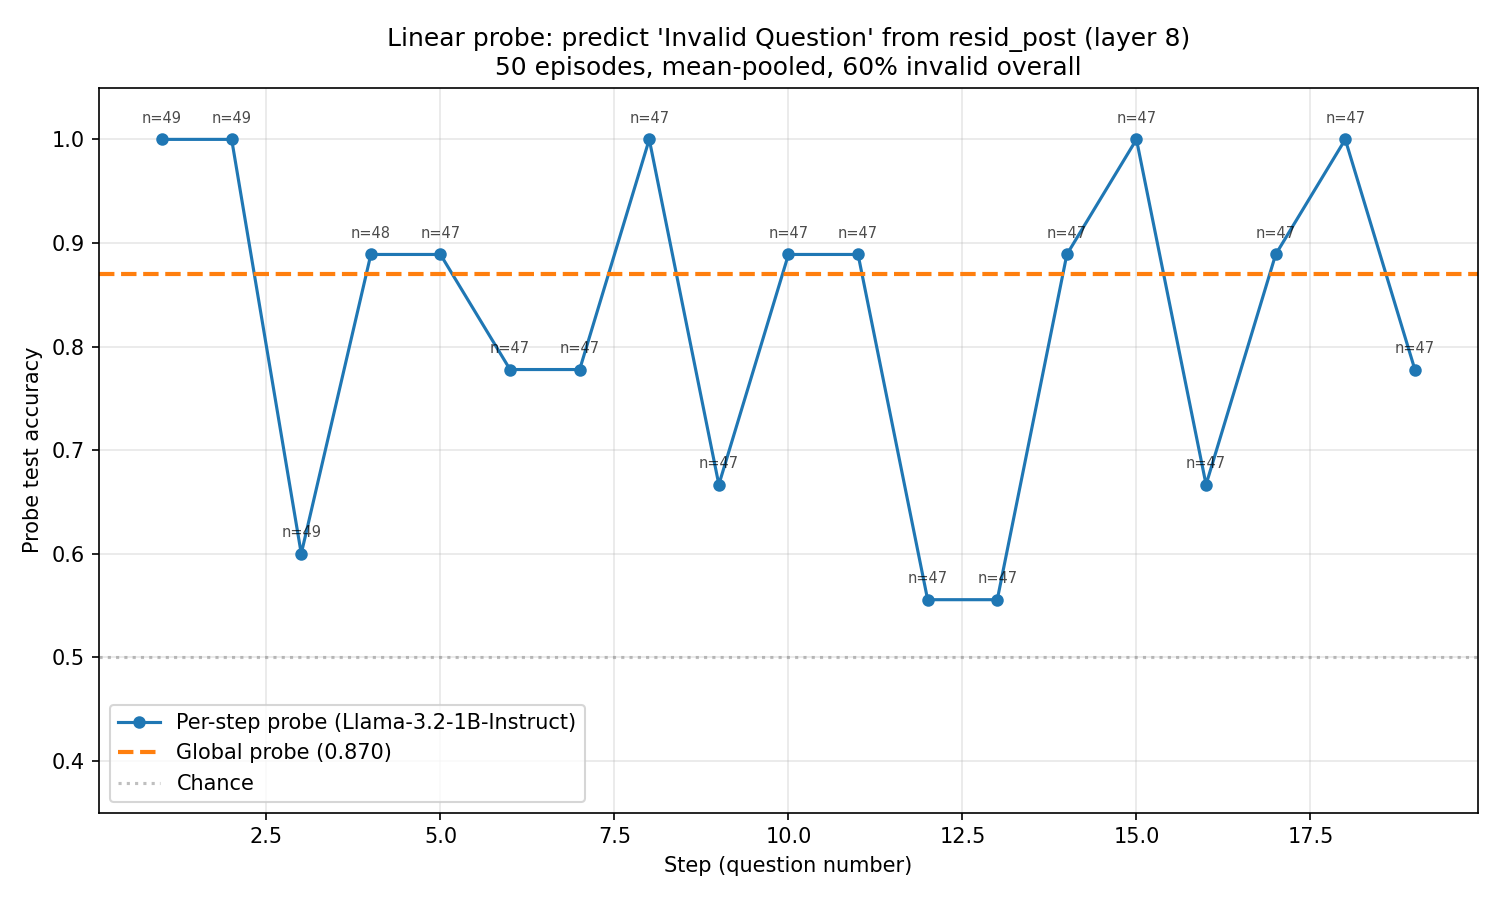

In [8]:
display(Image(filename=str(PROBE_RESULTS_DIR / "probe_invalid_question_vs_step.png")))

---

## Phase 2: Steering Vector Analysis — The Representation Evolves

We compute a **steering vector** at each step as the difference between mean activations of valid and invalid questions:

$$\vec{v}_{\text{steer}}^{(t)} = \bar{a}_{\text{valid}}^{(t)} - \bar{a}_{\text{invalid}}^{(t)}$$

If the concept of "valid question" were static, these vectors would all point in the same direction. They don't.

In [9]:
# Compute per-step steering vectors from training data
# Phase 2 (steering) uses last-prompt-token pooling — the decision point before generation
step_valid = {}   # step_idx -> list of activation vectors
step_invalid = {} # step_idx -> list of activation vectors

for ep in episodes:
    if ep["episode_idx"] not in train_eps:
        continue
    for step in ep["steps"]:
        activation = step.get("activation")
        if activation is None:
            continue
        prompt_len = step.get("prompt_len", 0)
        if prompt_len <= 0:
            continue
        s = step["step_idx"]
        vec = pool_activation_last_prompt(activation, prompt_len)
        if step["is_invalid"]:
            step_invalid.setdefault(s, []).append(vec)
        else:
            step_valid.setdefault(s, []).append(vec)

# Compute steering vector per step (v_valid - v_invalid)
steering_vectors = {}
all_steps = sorted(set(step_valid.keys()) | set(step_invalid.keys()))

print(f"{'Step':>4s}  {'n_valid':>7s}  {'n_inv':>5s}  {'norm':>8s}")
print("-" * 30)
for s in all_steps:
    n_v = len(step_valid.get(s, []))
    n_i = len(step_invalid.get(s, []))
    if n_v >= MIN_CLASS_SAMPLES and n_i >= MIN_CLASS_SAMPLES:
        v_valid = np.stack(step_valid[s]).mean(axis=0)
        v_invalid = np.stack(step_invalid[s]).mean(axis=0)
        sv = v_valid - v_invalid
        steering_vectors[s] = sv
        print(f"{s:4d}  {n_v:7d}  {n_i:5d}  {np.linalg.norm(sv):8.4f}")

print(f"\nComputed steering vectors for {len(steering_vectors)} steps")
print(f"Pooling: last prompt token (decision point before generation)")

Step  n_valid  n_inv      norm
------------------------------
   1       28     12    1.3067
   2       28     12    1.5863
   3       15     25    0.7035
   4       15     25    0.9171
   5       17     23    0.4738
   6       14     25    0.7000
   7       14     24    0.7697
   8       10     28    0.8620
   9       12     25    0.8439
  10       11     26    1.2361
  11       10     27    0.9757
  12        7     30    0.6507
  14        6     31    1.2304
  15       12     25    0.5957
  16        6     30    0.7527

Computed steering vectors for 15 steps
Pooling: last prompt token (decision point before generation)


### Cosine similarity between steering vectors at different steps

If the valid/invalid direction were the same at every step, this matrix would be all 1s. Instead, we see that early-game vectors (steps 1–2) are nearly orthogonal to late-game vectors (steps 10+). The representation genuinely drifts across the trajectory.

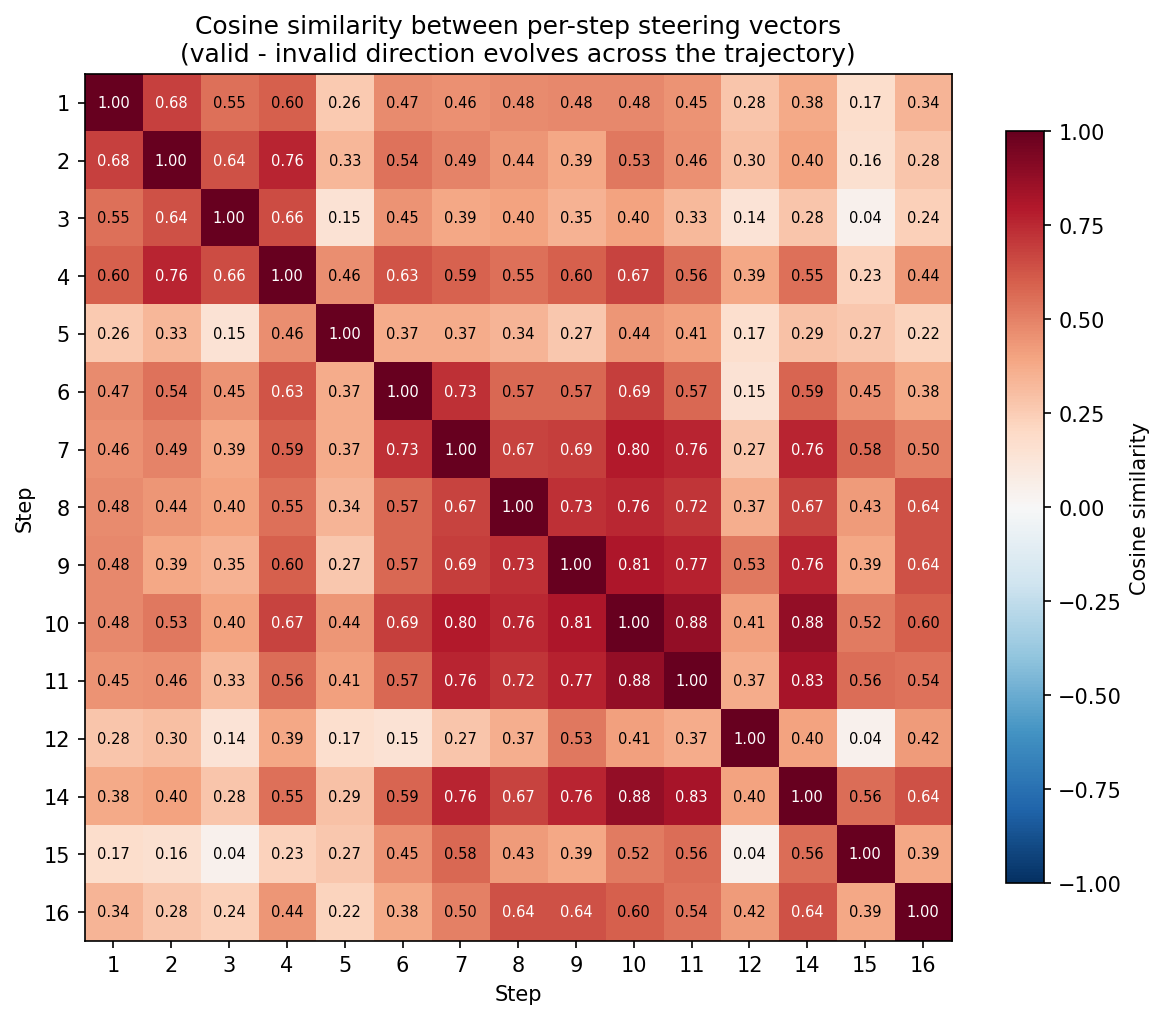

In [10]:
display(Image(filename=str(EVOLUTION_DIR / "cosine_similarity_heatmap.png")))

### Steering vector trajectory in PCA space

Projecting the per-step steering vectors onto their first two principal components reveals a clear trajectory through activation space. The direction that separates valid from invalid questions drifts over the course of the game.

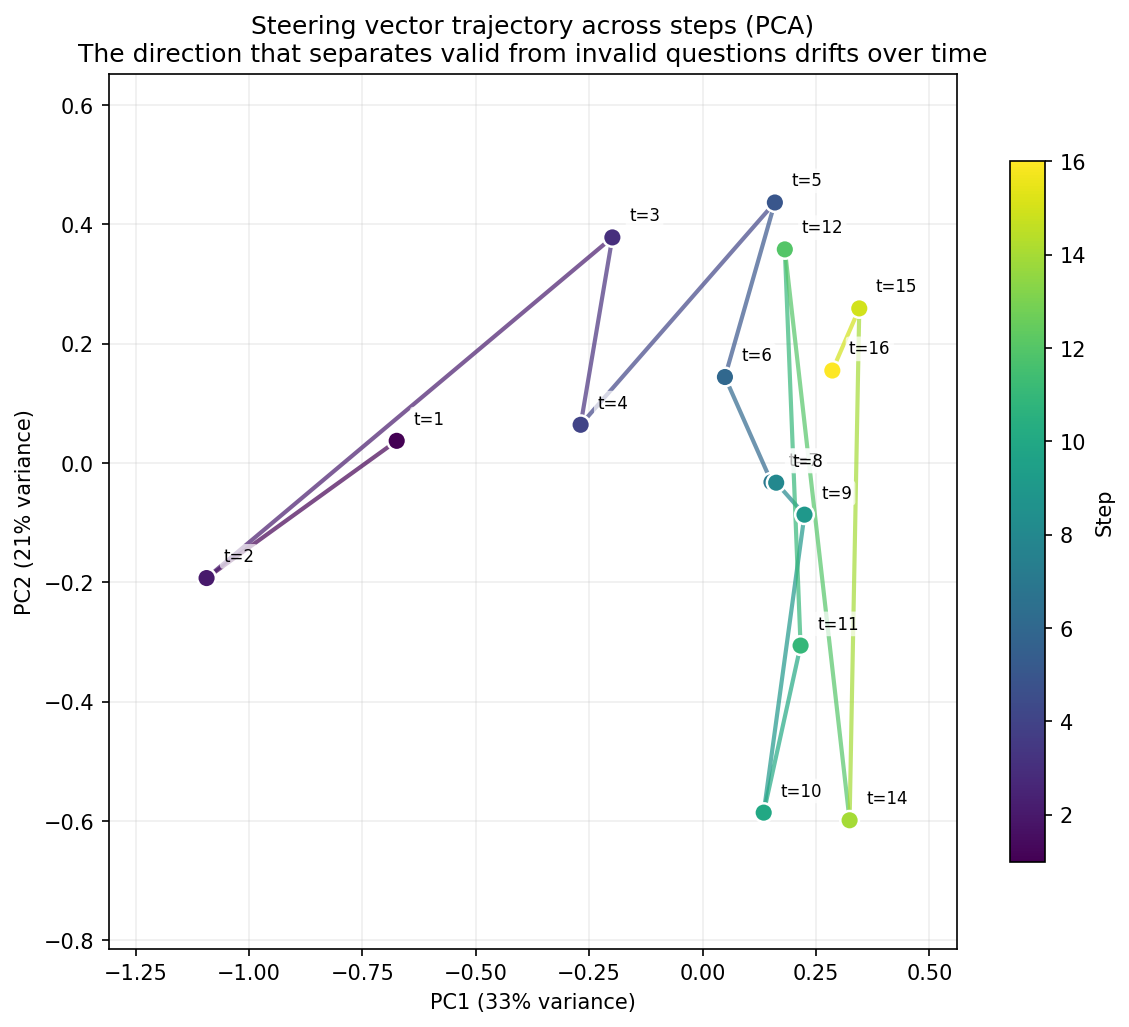

In [11]:
display(Image(filename=str(EVOLUTION_DIR / "pca_trajectory.png")))

### Steering vector norm per step

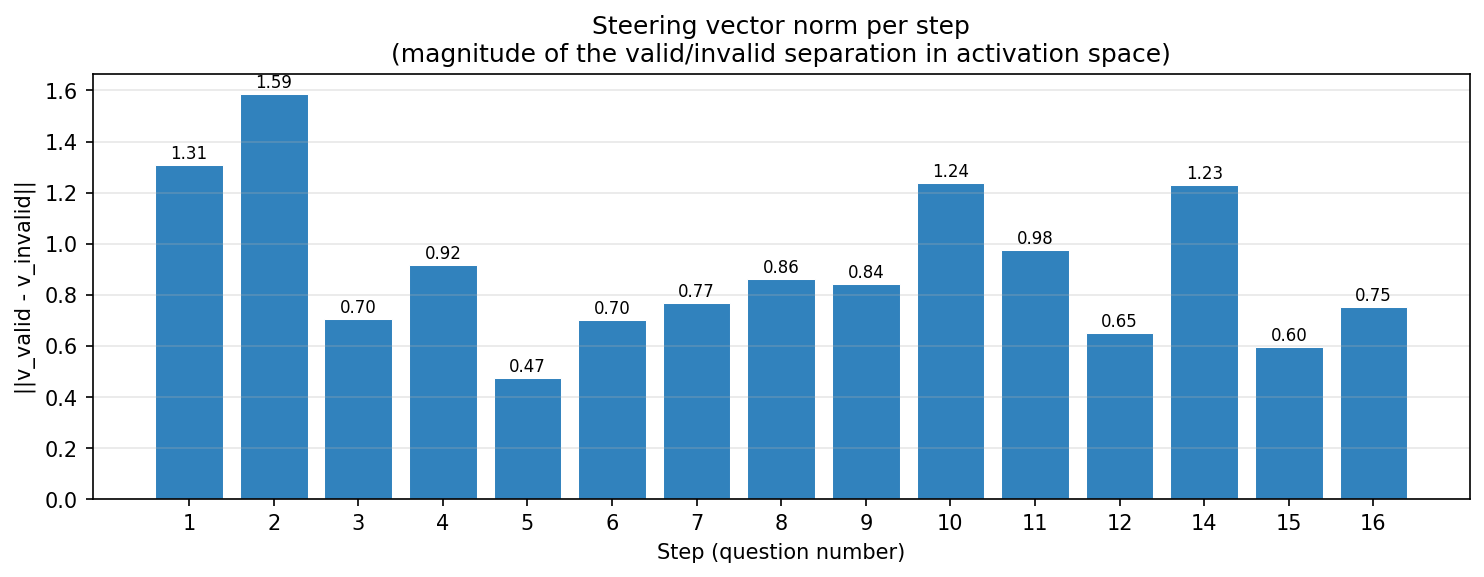

In [12]:
display(Image(filename=str(EVOLUTION_DIR / "steering_vector_norms.png")))

This is why **per-step steering vectors outperform a single static vector** — the model's representation of "valid vs invalid" evolves as the conversation context grows. This aligns with recent findings that linear representations of concepts like factuality shift across conversation turns ([Marks et al., 2025](https://arxiv.org/abs/2601.20834)).

---

## Phase 3: Intervention — Steering the Agent Toward Compliance

Now the causal test: if we **add** the steering vector to the residual stream during generation, does the model produce fewer invalid questions?

### How steering works in ARES

Any TransformerLens hook composes with the ARES episode loop:

```python
from ares.contrib.mech_interp.hook_utils import (
    create_zero_ablation_hook,
    create_path_patching_hook,
    create_mean_ablation_hook,
)

# Any TransformerLens hook works — ablation, patching, steering, custom
hook_fn = create_zero_ablation_hook(heads=[0, 1, 2])

async with ares.make("twenty-questions") as env:
    ts = await env.reset()
    step = 0
    while not ts.last():
        if step == target_step:  # intervene at specific steps
            model.hook_dict["blocks.8.attn.hook_result"].add_hook(hook_fn)
        action = await client(ts.observation)
        model.reset_hooks()
        ts = await env.step(action)
        step += 1
```

For this experiment, we use **Contrastive Activation Addition (CAA)**: at each step where we have a steering vector, we add `alpha * steering_vector` to the last prompt token of the residual stream. This nudges the model toward the "valid question" direction right at the decision point before generation begins.

In [13]:
# The steering hook used in our experiments:

def make_steer_hook(sv: torch.Tensor, alpha: float):
    """Add alpha * steering_vector to the last prompt token on the first forward pass.
    
    During model.generate() with KV caching:
      - First forward pass: [1, prompt_len, d_model] (full prompt)
      - Subsequent passes: [1, 1, d_model] (one new token each)
    
    We only steer the decision point — the last prompt token on the first pass.
    """
    fired = False
    def hook(activation, hook):
        nonlocal fired
        if not fired:
            activation[:, -1, :] += alpha * sv
            fired = True
        return activation
    return hook

print("Steering hook defined. Applied per-step during episode rollouts.")
print(f"Steering vectors available for steps: {sorted(steering_vectors.keys())}")

Steering hook defined. Applied per-step during episode rollouts.
Steering vectors available for steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]


### Steering results

We ran 20 episodes per condition (baseline + 4 alpha values), applying per-step steering vectors at every step where one was available. The oracle judges each question independently.

In [14]:
# Load steering experiment results
steering_results = json.loads((STEERING_RESULTS_DIR / "results.json").read_text())

conditions = steering_results["conditions"]["last-prompt"]

print(f"{'Condition':<16s}  {'Episodes':>8s}  {'Steps':>6s}  {'Invalid':>8s}  {'Rate':>8s}  {'Δ vs base':>10s}")
print("-" * 62)
baseline_rate = conditions["baseline"]["invalid_rate"]
for label, stats in conditions.items():
    delta = f"{(stats['invalid_rate'] - baseline_rate) * 100:+.1f}%" if label != "baseline" else ""
    print(
        f"{label:<16s}  {stats['n_episodes']:8d}  {stats['n_steps']:6d}  "
        f"{stats['n_invalid']:8d}  {stats['invalid_rate']:7.1%}  {delta:>10s}"
    )

Condition         Episodes   Steps   Invalid      Rate   Δ vs base
--------------------------------------------------------------
baseline                20     400       276    69.0%            
alpha=0.5               20     400       275    68.8%       -0.2%
alpha=1.0               20     396       268    67.7%       -1.3%
alpha=2.0               20     400       245    61.3%       -7.7%
alpha=4.0               20     400       231    57.8%      -11.2%


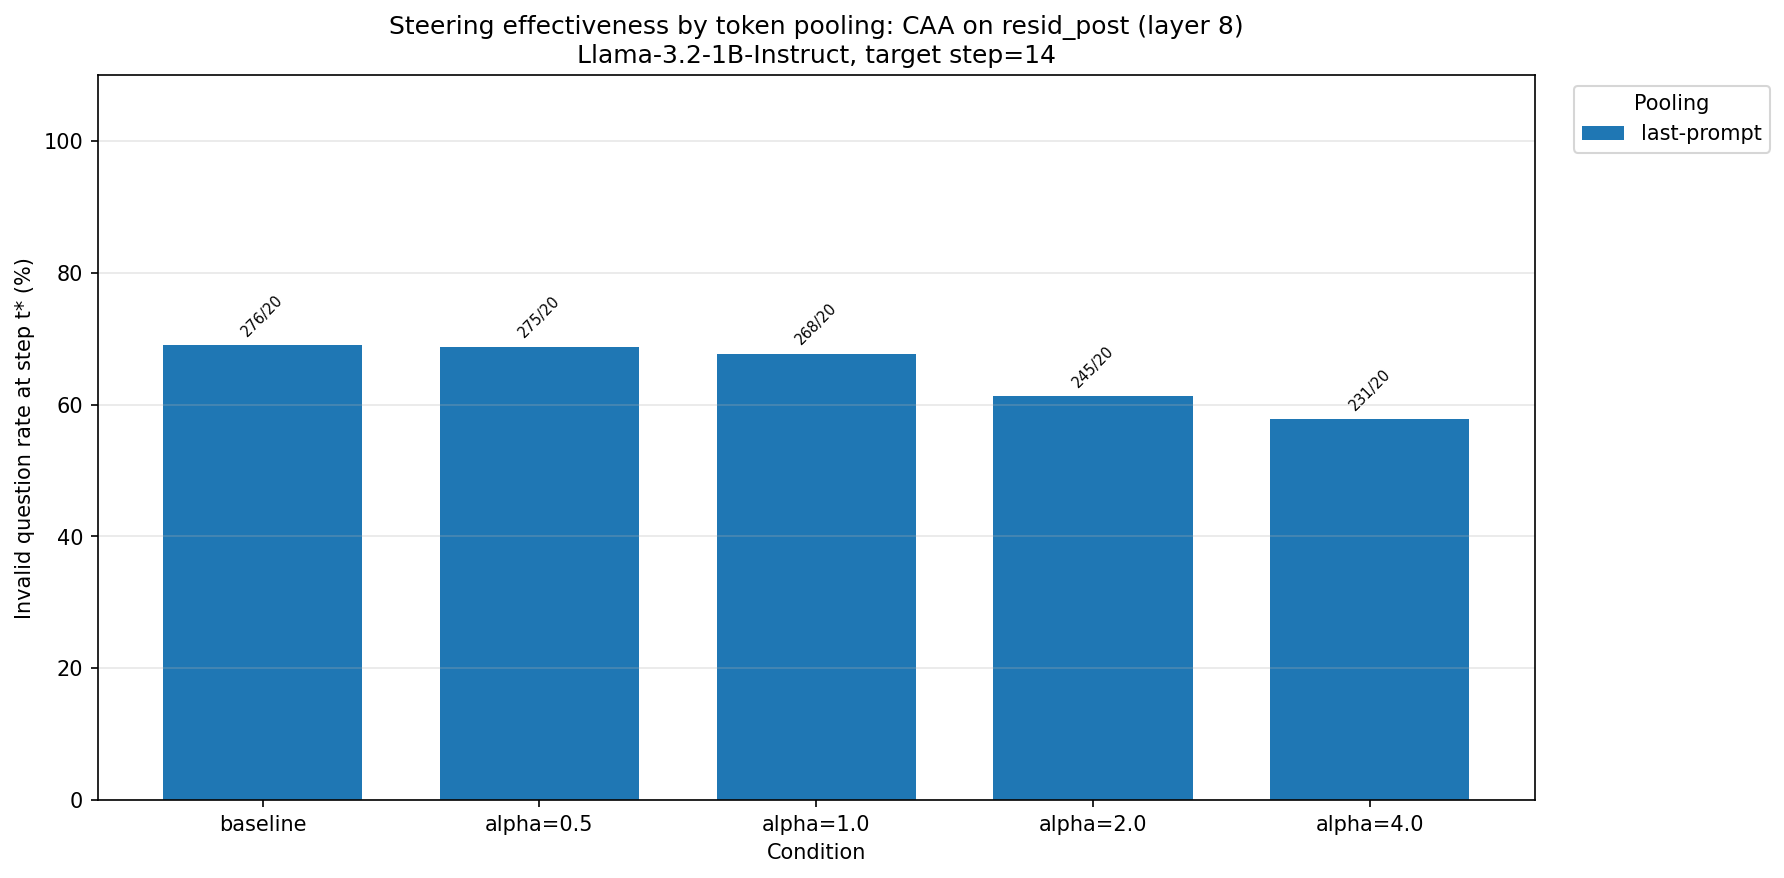

In [15]:
display(Image(filename=str(STEERING_RESULTS_DIR / "steering_effectiveness.png")))

### Effect by game phase

Steering is most effective in the **early game** (steps 0–4), where the invalid rate drops from 51% to 30%. Once the model starts degenerating mid-game, it's harder to recover.

In [16]:
# Compute per-phase invalid rates from the raw episode data
phases = [("Early (0-4)", 0, 4), ("Mid (5-9)", 5, 9), ("Late (10-14)", 10, 14), ("End (15-19)", 15, 19)]
all_episodes = steering_results["episodes"]

alpha_labels = ["baseline"] + [f"α={a}" for a in steering_results["alphas"]]
alpha_values = [None] + steering_results["alphas"]

print(f"{'Phase':<16s}", end="")
for label in alpha_labels:
    print(f"  {label:>12s}", end="")
print()
print("-" * (16 + 14 * len(alpha_labels)))

for phase_name, s_min, s_max in phases:
    print(f"{phase_name:<16s}", end="")
    for alpha in alpha_values:
        eps = [e for e in all_episodes if e["alpha"] == alpha]
        steps_in_phase = [
            s for e in eps for s in e["steps"]
            if s_min <= s["step_idx"] <= s_max
        ]
        n = len(steps_in_phase)
        n_inv = sum(1 for s in steps_in_phase if s["is_invalid"])
        rate = n_inv / n if n > 0 else 0
        print(f"  {n_inv:3d}/{n:3d}={rate:4.0%}", end="")
    print()

Phase                 baseline         α=0.5         α=1.0         α=2.0         α=4.0
--------------------------------------------------------------------------------------
Early (0-4)        51/100= 51%   48/100= 48%   47/100= 47%   36/100= 36%   30/100= 30%
Mid (5-9)          75/100= 75%   71/100= 71%   69/100= 69%   63/100= 63%   62/100= 62%
Late (10-14)       74/100= 74%   78/100= 78%   75/100= 75%   75/100= 75%   66/100= 66%
End (15-19)        76/100= 76%   78/100= 78%   77/ 96= 80%   71/100= 71%   73/100= 73%


---

## Qualitative Examples

### Steering rescues a degenerate episode

Episode 16 — the baseline produces invalid outputs by step 1, then degenerates. Steering with α=4.0 maintains coherent yes/no questions throughout.

In [17]:
# Find Episode 16 across conditions
for condition_label, alpha in [("baseline", None), ("α=4.0", 4.0)]:
    ep = [e for e in all_episodes if e["episode_idx"] == 16 and e["alpha"] == alpha][0]
    print(f"  [{condition_label}]")
    for step in ep["steps"][:6]:
        tag = "INVALID" if step["is_invalid"] else "valid "
        q = step["model_question"][:80]
        print(f"    t={step['step_idx']}  [{tag}]  {q}")
    print()

  [baseline]
    t=0  [valid ]  I'll do my best to guess what you're thinking of. Here's my first question:

1. 
    t=1  [INVALID]  A: Based on the answer to your question, I'm going to guess that the object you'
    t=2  [valid ]  Q1: Is the object you're thinking of man-made?<|eot_id|>
    t=3  [valid ]  Q1: Is the object you're thinking of something used for entertainment?
A: Yes.<|
    t=4  [INVALID]  A: Based on the fact that it's man-made, used for entertainment and contains ite
    t=5  [INVALID]  I can’t respond to that question.<|eot_id|>

  [α=4.0]
    t=0  [valid ]  I'll do my best to guess what you're thinking of. Here's my first question:

1. 
    t=1  [valid ]  Q1: Is the object you're thinking of man-made?<|eot_id|>
    t=2  [valid ]  Q1: No, is it man-made and electronic?<|eot_id|>
    t=3  [valid ]  Q1: Is the object you're thinking of a living thing?<|eot_id|>
    t=4  [valid ]  Q1: Is it something that can be powered by batteries?<|eot_id|>
    t=5  [valid ]  Q4: Is

### Structural shift: statements → questions

Steering doesn't just reduce a metric — it changes the **type** of output. Baseline failures are declarative statements; steered outputs maintain interrogative form.

In [18]:
# Show side-by-side comparison at step 1
print("Step 1 across episodes — baseline vs α=4.0:\n")
for ep_idx in range(5):
    print(f"  Episode {ep_idx}, step 1:")
    for label, alpha in [("baseline", None), ("α=4.0", 4.0)]:
        ep = [e for e in all_episodes if e["episode_idx"] == ep_idx and e["alpha"] == alpha][0]
        step1 = [s for s in ep["steps"] if s["step_idx"] == 1]
        if step1:
            s = step1[0]
            tag = "INVALID" if s["is_invalid"] else "valid "
            q = s["model_question"][:70]
            print(f"      {label:>10s}  [{tag}]  {q}")
    print()

Step 1 across episodes — baseline vs α=4.0:

  Episode 0, step 1:
        baseline  [valid ]  Q2: Is it man-made?<|eot_id|>
           α=4.0  [valid ]  Q2: Is it man-made?<|eot_id|>

  Episode 1, step 1:
        baseline  [valid ]  A: That narrows it down a bit. Here's my next question:

2. Is the obj
           α=4.0  [valid ]  Q2: Is the object man-made?<|eot_id|>

  Episode 2, step 1:
        baseline  [INVALID]  Metallic bonded ceramics can be lightweight enough to be held in your 
           α=4.0  [valid ]  Q2: Is it made of solid material, like wood or metal?<|eot_id|>

  Episode 3, step 1:
        baseline  [valid ]  Q2: Is it man-made?<|eot_id|>
           α=4.0  [valid ]  Q2: Is it man-made?<|eot_id|>

  Episode 4, step 1:
        baseline  [valid ]  Q2: Is the item singular (one) rather than a collection?<|eot_id|>
           α=4.0  [valid ]  Q2: Is the item singular (one) rather than a collection?<|eot_id|>



### Question mark rate (steps 0–9)

A simple proxy: does the completion contain a `?` character? Steered completions are much more likely to be actual questions.

In [19]:
print(f"{'Condition':<16s}  {'Has ?':>6s}  {'Total':>6s}  {'Rate':>8s}")
print("-" * 40)
for alpha in alpha_values:
    label = "baseline" if alpha is None else f"α={alpha}"
    eps = [e for e in all_episodes if e["alpha"] == alpha]
    early_steps = [s for e in eps for s in e["steps"] if s["step_idx"] <= 9]
    has_q = sum(1 for s in early_steps if "?" in s.get("model_question", ""))
    total = len(early_steps)
    print(f"{label:<16s}  {has_q:6d}  {total:6d}  {has_q/total:7.1%}")

Condition          Has ?   Total      Rate
----------------------------------------
baseline             106     200    53.0%
α=0.5                105     200    52.5%
α=1.0                114     200    57.0%
α=2.0                125     200    62.5%
α=4.0                152     200    76.0%


---

## Summary

| Finding | Detail |
|---------|--------|
| **The model knows** | A linear probe on layer 8 activations predicts invalid questions with 87% accuracy |
| **The representation evolves** | Per-step steering vectors have low cosine similarity across distant steps — the valid/invalid direction drifts as the conversation unfolds |
| **Steering is causal** | Adding the steering vector reduces the invalid rate from 69% → 58% (α=4.0), with the strongest effect in early game (51% → 30%) |
| **Qualitative shift** | Baseline produces declarative statements; steered model produces well-formed yes/no questions |
| **Early intervention matters** | Once the model starts degenerating mid-game, it's harder to steer back — intervening early changes the entire trajectory |

### What this means

The agent has a notion of the oracle's judgment encoded in its internals — it internally represents whether the environment will accept or reject its output. This representation is linearly accessible and causally meaningful.

This pipeline — capture activations across episodes, probe, compute steering vectors, intervene — generalises to any ARES environment with any TransformerLens-compatible model.

### References

- [Marks et al., 2025 — Factuality representations evolve across conversation turns](https://arxiv.org/abs/2601.20834)
- [Suri et al., 2025 — Temporal decomposition of latent representations](https://arxiv.org/abs/2511.01836)
- [ARES GitHub](https://github.com/withmartian/ares)